In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.core.display import HTML, display
import time
from typing import Callable, Union

In [2]:
from umap import UMAP
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap
from sklearn.decomposition import PCA, SparsePCA, NMF, KernelPCA
from sklearn.ensemble import IsolationForest

# Setup
Setup environment such as themes, colors, seed

In [3]:
colors = ['lightpink','deepskyblue','orange', 'lime',
          'magenta','yellow','green','red','powderblue']

pypat_vanja = ListedColormap(colors)
matplotlib.style.use('default')
# matplotlib.style.use('dark_background')

In [4]:
# Fix seed
seed = 42069
np.random.seed(seed)

# Data analysis and preprocessing

In [5]:
df_raw = pd.read_csv('OSEBX_dataset.csv')
df = df_raw.copy()

In [6]:
def print_html(df: pd.DataFrame):
    '''Display give DataFrame as HTML table'''
    display(HTML(df.to_html()))

In [7]:
n_data, n_features = df.shape[0], df.shape[1]
print(f'There are in total {n_data} data points')
print(f'There are in total {n_features} features')

There are in total 246 data points
There are in total 21 features


### Inspecting the raw data

Sampling 10 random samples without replacement to inspect the features and values. 


In [8]:
print_html(df.sample(10, random_state=seed))

,ticker,name,sector,last_,buy,sell,tradecount,info,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
176,SALM,SalMar,Consumer staples,468.20,468.00,468.30,753,NaN,52870.48,-0.0112,0.0067,0.0272,0.0410,0.1293,73.818,5.735365e+10,26.429,28.73,6.339917,-0.313360,0.24618
12,AKVA,AKVA Group,Industrials,73.00,72.80,73.80,2,LP,2416.77,-0.0135,-0.0267,-0.0214,-0.0135,0.1057,32.930,3.543555e+09,3.560,5.73,2.216824,0.038866,0.03760
193,SOGN,Sogn Sparebank,Equity certificates,105.00,103.00,106.00,0,LP,66.41,NaN,NaN,-0.0094,-0.0187,0.0202,1411.696,-7.422935e+08,7.366,NaN,0.074379,-0.083400,0.26904
173,ROM,RomReal,Real estate,2.34,2.10,2.34,1,NaN,96.69,0.1038,NaN,0.0086,0.0174,0.1471,0.574,8.769970e+07,0.041,NaN,4.076655,-0.553036,0.00000
120,NAPA,Napatech,Information technology,4.62,4.54,4.62,28,NaN,383.73,-0.0274,0.0176,-0.0128,-0.0107,0.6934,0.397,1.515840e+08,-0.862,NaN,11.637279,-0.651012,-0.36110
16,ARCHER,Archer,Energy,2.90,2.91,2.95,97,NaN,429.01,-0.0705,-0.1131,-0.0397,-0.0881,-0.4165,0.656,1.109282e+09,-0.740,0.06,4.420732,3.076923,-0.12929
206,SBTE,Sparebanken Telemark,Equity certificates,132.00,129.00,132.00,2,NaN,1438.62,0.0076,0.0000,0.0154,0.0154,0.1880,313.526,7.386721e+09,15.338,NaN,0.421018,NaN,0.42772
69,FUNCOM,Funcom,Communication services,16.96,16.94,16.96,166,NaN,1310.79,0.0000,0.2535,0.2947,0.2897,0.3520,0.582,1.299098e+09,0.013,NaN,29.140890,0.675303,0.04663
115,MEDI,Medistim,Health care,216.00,214.00,218.00,83,NaN,3930.95,0.0286,0.0800,0.1489,0.1250,2.2388,12.268,3.780276e+09,4.328,2.64,16.628628,-0.152226,0.21678
196,SBVG,SpareBank 1 BV,Equity certificates,40.00,40.00,40.10,7,LP,2520.30,-0.0074,-0.0196,0.0178,0.0101,0.1794,81.579,1.016877e+10,4.591,4.12,0.490322,0.400809,0.42746


In [9]:
print_html(df.describe())

,last_,buy,sell,tradecount,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
count,246.000000,243.000000,242.000000,246.000000,246.000000,216.000000,217.000000,237.000000,240.000000,221.000000,226.000000,2.300000e+02,225.000000,148.000000,218.000000,204.000000,234.000000
mean,78.113943,78.396872,79.803388,189.715447,11461.090122,-0.024863,-0.033271,0.005018,-0.009210,0.148537,71.011403,2.048528e+10,3.072702,4.075878,6.236073,0.612347,0.068793
std,190.021210,188.569359,191.746736,452.737344,45161.177124,0.033151,0.075254,0.160991,0.143406,0.710345,194.566805,8.169472e+10,11.201345,7.255279,11.034168,1.156198,1.019313
min,0.040000,0.040000,0.040000,0.000000,1.300000,-0.098000,-0.243200,-0.325900,-0.392700,-0.999100,-40.465000,-7.422935e+08,-45.601000,-20.180000,0.007204,-11.622199,-2.338370
25%,6.475000,6.675000,6.985000,5.000000,344.875000,-0.046725,-0.071800,-0.070600,-0.085925,-0.215400,1.837250,6.196852e+08,-0.347000,0.077500,0.999795,0.167611,-0.029625
50%,28.450000,28.600000,30.345000,25.500000,1684.675000,-0.025450,-0.032400,-0.004400,-0.009900,0.099900,8.195500,3.232074e+09,0.172000,1.180000,3.276253,0.535051,0.029295
75%,93.150000,95.650000,97.025000,151.750000,5726.720000,-0.008075,0.000000,0.052600,0.043075,0.315200,33.575500,1.051254e+10,3.734000,6.455000,6.758276,0.983401,0.141410
max,2650.000000,2610.000000,2650.000000,4295.000000,578350.150000,0.129000,0.460800,1.058000,0.900500,5.171400,1411.696000,9.799314e+11,90.434000,31.330000,114.480194,4.485829,12.562961


In [10]:
# Encode string labels to numerical
sectorencoder = LabelEncoder()
infoencoder = LabelEncoder()
df['sector'] = sectorencoder.fit_transform(df['sector'])
df['info'].fillna('nLP', inplace=True)
df['info'] = infoencoder.fit_transform(df['info'])

In [11]:
print(df.sample(10, random_state=seed)[['sector','info']])

     sector  info
176       2     1
12        7     0
193       4     0
173      10     1
120       8     1
16        3     1
206       4     1
69        0     1
115       6     1
196       4     0


In [12]:
print_html(df.head())

,ticker,name,sector,last_,buy,sell,tradecount,info,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
0,2020,2020 Bulkers,7,74.00,74.40,77.00,6,1,1640.65,-0.0513,-0.0513,-0.1153,-0.1516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,FIVEPG,5th Planet Games,0,0.42,0.39,0.40,7,0,22.35,0.0400,0.2058,0.1954,0.1274,-0.7227,0.174,1.979840e+07,-0.118,NaN,2.390805,1.302454,0.00000
2,AASB-ME,Aasen Sparebank,4,134.00,130.00,138.00,0,0,135.86,NaN,NaN,0.0388,0.0388,0.2622,NaN,NaN,NaN,NaN,NaN,0.239307,0.40017
3,ASC,ABG Sundal Collier Holding,5,4.01,4.01,4.03,48,1,1831.24,-0.0243,-0.0302,0.0088,0.0050,-0.0187,1.442,1.598438e+09,0.305,0.43,2.780860,0.827530,0.13757
4,ADE,Adevinta,0,107.40,107.40,108.00,60,1,73563.47,-0.0147,0.0037,0.0427,0.0327,NaN,NaN,7.424512e+10,NaN,NaN,NaN,NaN,0.04859


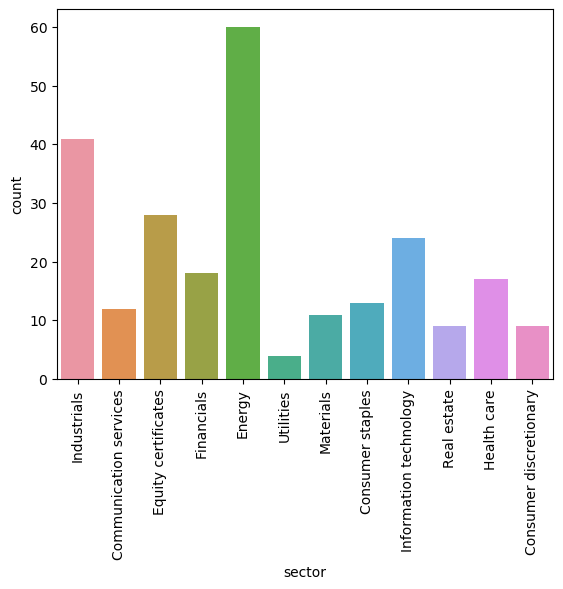

In [13]:
cplot = sns.countplot(df_raw.sector)
cplot.set_xticklabels(cplot.get_xticklabels(), rotation=90)
plt.show()

# Bivariate Statistics

In [14]:
# sns.pairplot(df, height=1)
# plt.show()

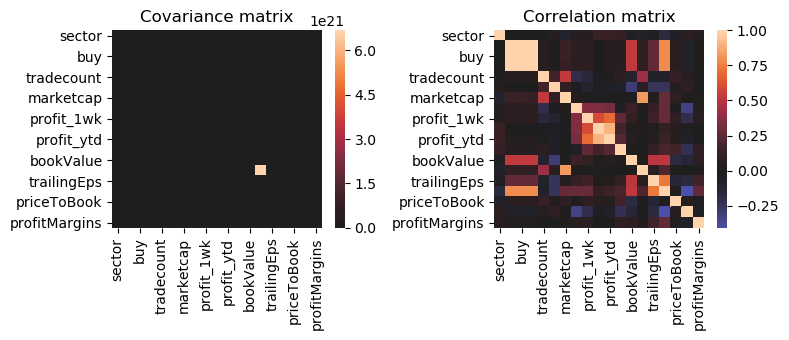

In [15]:
covmat = df.cov()
cormat = df.corr()

fig, axes = plt.subplots(1, 2, figsize=(8,3.5))
sns.heatmap(covmat, ax=axes[0], center=0)
sns.heatmap(cormat, ax=axes[1], center=0)
axes[0].set_title('Covariance matrix')
axes[1].set_title('Correlation matrix')
fig.tight_layout(rect=(0,0,1,1))
plt.show()

From correlation matrix, find the top 3 correlated features

In [16]:
abscormat = cormat.abs()
triabscormat = abscormat.where(np.triu(np.ones(abscormat.shape), k=1).astype(bool)).stack()
print(list(triabscormat.sort_values(ascending=False).index[:3]))

[('last_', 'buy'), ('last_', 'sell'), ('buy', 'sell')]


In [17]:
viz_features = np.unique(list(triabscormat.sort_values(ascending=False).index[0:3]))
print(viz_features)

['buy' 'last_' 'sell']


In [18]:
print_html(df.sample(10))

,ticker,name,sector,last_,buy,sell,tradecount,info,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
176,SALM,SalMar,2,468.20,468.00,468.30,753,1,52870.48,-0.0112,0.0067,0.0272,0.0410,0.1293,73.818,5.735365e+10,26.429,28.73,6.339917,-0.313360,0.24618
12,AKVA,AKVA Group,7,73.00,72.80,73.80,2,0,2416.77,-0.0135,-0.0267,-0.0214,-0.0135,0.1057,32.930,3.543555e+09,3.560,5.73,2.216824,0.038866,0.03760
193,SOGN,Sogn Sparebank,4,105.00,103.00,106.00,0,0,66.41,NaN,NaN,-0.0094,-0.0187,0.0202,1411.696,-7.422935e+08,7.366,NaN,0.074379,-0.083400,0.26904
173,ROM,RomReal,10,2.34,2.10,2.34,1,1,96.69,0.1038,NaN,0.0086,0.0174,0.1471,0.574,8.769970e+07,0.041,NaN,4.076655,-0.553036,0.00000
120,NAPA,Napatech,8,4.62,4.54,4.62,28,1,383.73,-0.0274,0.0176,-0.0128,-0.0107,0.6934,0.397,1.515840e+08,-0.862,NaN,11.637279,-0.651012,-0.36110
16,ARCHER,Archer,3,2.90,2.91,2.95,97,1,429.01,-0.0705,-0.1131,-0.0397,-0.0881,-0.4165,0.656,1.109282e+09,-0.740,0.06,4.420732,3.076923,-0.12929
206,SBTE,Sparebanken Telemark,4,132.00,129.00,132.00,2,1,1438.62,0.0076,0.0000,0.0154,0.0154,0.1880,313.526,7.386721e+09,15.338,NaN,0.421018,NaN,0.42772
69,FUNCOM,Funcom,0,16.96,16.94,16.96,166,1,1310.79,0.0000,0.2535,0.2947,0.2897,0.3520,0.582,1.299098e+09,0.013,NaN,29.140890,0.675303,0.04663
115,MEDI,Medistim,6,216.00,214.00,218.00,83,1,3930.95,0.0286,0.0800,0.1489,0.1250,2.2388,12.268,3.780276e+09,4.328,2.64,16.628628,-0.152226,0.21678
196,SBVG,SpareBank 1 BV,4,40.00,40.00,40.10,7,0,2520.30,-0.0074,-0.0196,0.0178,0.0101,0.1794,81.579,1.016877e+10,4.591,4.12,0.490322,0.400809,0.42746


# Look here to select which features to exclude

In [19]:
# Separate data and labels for conventional purposes
dfx = df.drop(columns=['name', 'ticker', 'tradecount', 'sector','info']).fillna(0)
X, y = dfx.values, df.sector.values.flatten()

# print_html(dfx)

In [20]:
print(X)

[[ 7.4000000e+01  7.4400000e+01  7.7000000e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.2000000e-01  3.9000000e-01  4.0000000e-01 ...  2.3908048e+00
   1.3024540e+00  0.0000000e+00]
 [ 1.3400000e+02  1.3000000e+02  1.3800000e+02 ...  0.0000000e+00
   2.3930700e-01  4.0016997e-01]
 ...
 [ 3.1500000e+01  3.1500000e+01  3.1700000e+01 ...  6.6065435e+00
   8.9554600e-01 -1.0360000e-02]
 [ 2.3000000e-01  2.3000000e-01  2.3000000e-01 ...  0.0000000e+00
   1.4584610e+00 -1.6545400e+00]
 [ 6.4000000e+00  6.4000000e+00  6.5000000e+00 ...  1.2749004e+00
   0.0000000e+00  0.0000000e+00]]


In [21]:
minmaxscaler = MinMaxScaler().fit(X)
# standardscaler = StandardScaler().fit(X)
# robustscaler = RobustScaler().fit(X)

X_minmax = minmaxscaler.transform(X)
# X_standard = standardscaler.transform(X)
# X_robust = robustscaler.transform(X)

In [22]:
def scatter2d3d(df, theta=(45,45), aspect_equal: bool = False, figsize: tuple = (12,4), *args, **kwargs) -> tuple:
    '''
    Given a dataframe with at least three columns, scatterplot the data on a 3D axes object as well as 
    all the 2D projections of the axes. The columns names of the dataframe will be used as axes names.  
    '''
    X = df.values
    fnames = df.columns 

    # Create figure and axes
    fig = plt.figure(figsize=figsize)    
    axes = [fig.add_subplot(141, projection='3d'), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)]  

    axes[0].scatter(*X[:,[0,1,2]].T, *args, **kwargs)
    axes[1].scatter(*X[:,[0,1]].T, *args, **kwargs)
    axes[2].scatter(*X[:,[1,2]].T, *args, **kwargs)
    axes[3].scatter(*X[:,[0,2]].T, *args, **kwargs)
    
    axes[0].view_init(*theta)
    plt.setp(axes[0], xlabel=fnames[0], ylabel=fnames[1], zlabel=fnames[2])
    plt.setp(axes[1], xlabel=fnames[0], ylabel=fnames[1])
    plt.setp(axes[2], xlabel=fnames[1], ylabel=fnames[2])
    plt.setp(axes[3], xlabel=fnames[0], ylabel=fnames[2])
    
    [ax.grid() for ax in axes]
    if aspect_equal:
        [ax.set_aspect('equal') for ax in axes]

    fig.tight_layout()
    return fig, axes

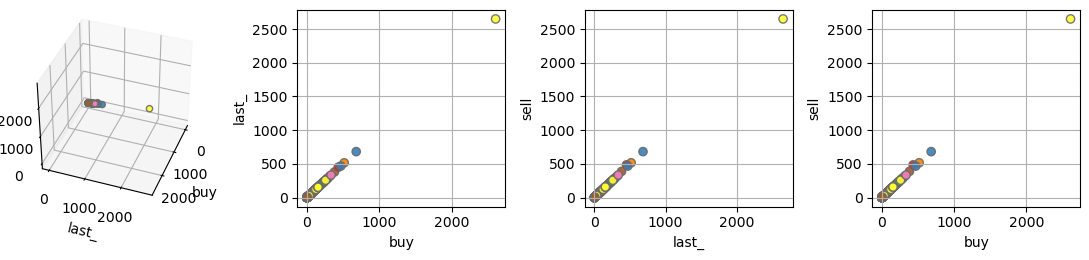

In [23]:
scatter2d3d(df[viz_features], (40,20), c=y, figsize=(11,2.7), edgecolor='dimgrey', cmap='Set1', alpha=0.9)
plt.show()

In [24]:
def name(obj) -> str:
    '''Get string name of obj, works for functions and instances'''
    return obj.__name__ if isinstance(obj, Callable) else obj.__class__.__name__

In [25]:
def get_visualizations(X: np.ndarray, visualizers: list, show: bool=False) -> dict:
    '''
    Takes in X and returns a list of all visualizeres from Sklearn-API visualization
    (e.g. UMAP) algorithms. Visualizers should be allocated objects. Returns a dicitonary
    with the names of the visualizers and the values are the result from said visualizer.
    '''
    transforms = dict()
    for i, viz in enumerate(visualizers):
        algoname = name(viz)
        t0 = time.time()
        print(f'Running {algoname}', end='')
        temp = viz.fit_transform(X)
        print(f'\r{algoname} transformed in {time.time()-t0:.2f} seconds')
        
        # If same type of function is used multiple times
        if algoname in transforms:
            transforms[algoname+f'{i}'] = temp
        else:
            transforms[algoname] = temp
        
    print()
    return transforms

In [26]:
def show_visualizations(vizzes: dict, y: np.ndarray, title=None, **kwargs) -> None:
    '''
    Takes in a dictionary where keys are name of an algroithm, e.g UMAP and the corresponding
    value is 2D plot data.
    '''
    n_viz = len(vizzes)
    
    fig, axes = plt.subplots(1, n_viz, figsize=(3*n_viz, 0.6*n_viz))
    
    for ax, name, X in zip(axes, vizzes.keys(), vizzes.values()):
        ax.scatter(*X.T, c=y, **kwargs)
        ax.set_title(name)
    
    if title:
        fig.suptitle(title)
        fig.tight_layout(rect=(0,0,1,0.90))
    else:
        fig.tight_layout()

    plt.show()

In [27]:
common_viz_kwargs = dict(n_components=2, random_state=seed)
vizgroup1 = [UMAP(n_epochs=500, n_neighbors=10, **common_viz_kwargs), MDS(n_init=4, n_jobs=-1, **common_viz_kwargs), PCA(**common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=10, **common_viz_kwargs), Isomap(n_neighbors=10, n_components=2)]
vizgroup2 = [UMAP(n_epochs=500, n_neighbors=20, **common_viz_kwargs), MDS(n_init=8, n_jobs=-1, **common_viz_kwargs), KernelPCA(kernel='rbf', **common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=20, **common_viz_kwargs), Isomap(n_neighbors=20, n_components=2)]
vizgroup3 = [UMAP(n_epochs=500, n_neighbors=30, **common_viz_kwargs), MDS(n_init=12, n_jobs=-1, **common_viz_kwargs), SparsePCA(normalize_components=True, **common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=30, **common_viz_kwargs), Isomap(n_neighbors=30, n_components=2)]

In [28]:
vizzes1 = get_visualizations(X_minmax, vizgroup1)
vizzes2 = get_visualizations(X_minmax, vizgroup2)
vizzes3 = get_visualizations(X_minmax, vizgroup3)

UMAP transformed in 5.62 seconds
MDS transformed in 4.02 seconds
PCA transformed in 0.00 seconds
LocallyLinearEmbedding transformed in 0.09 seconds
Isomap transformed in 0.07 seconds

UMAP transformed in 0.71 seconds
MDS transformed in 2.77 seconds
KernelPCA transformed in 0.00 seconds
LocallyLinearEmbedding transformed in 0.08 seconds
Isomap transformed in 0.08 seconds

UMAP transformed in 0.80 seconds
MDS transformed in 3.35 seconds
SparsePCA transformed in 0.03 seconds
LocallyLinearEmbedding transformed in 0.10 seconds
Isomap transformed in 0.09 seconds



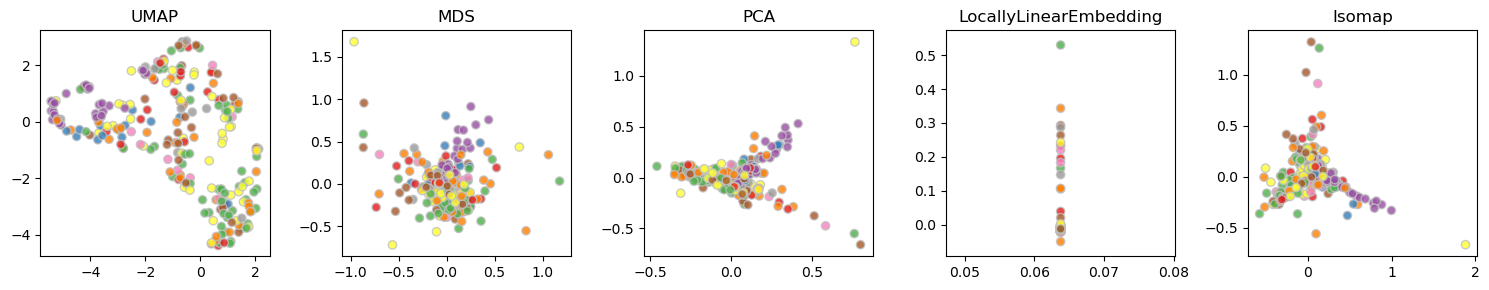

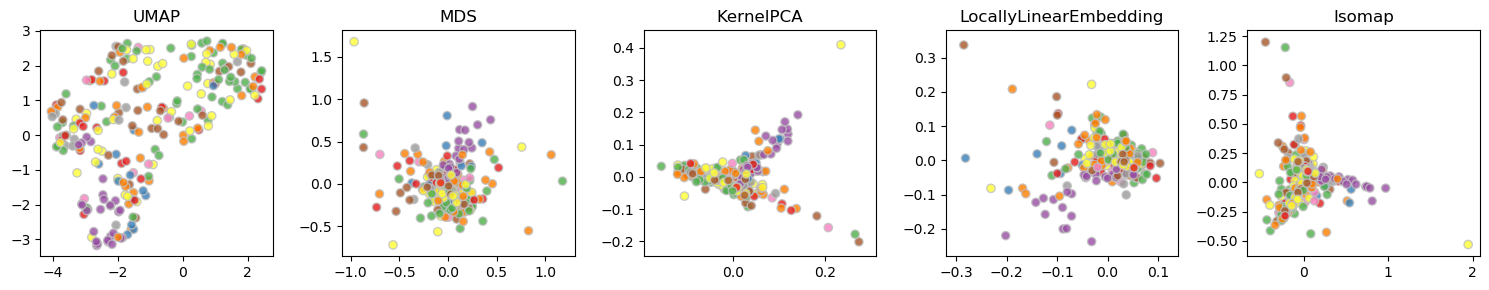

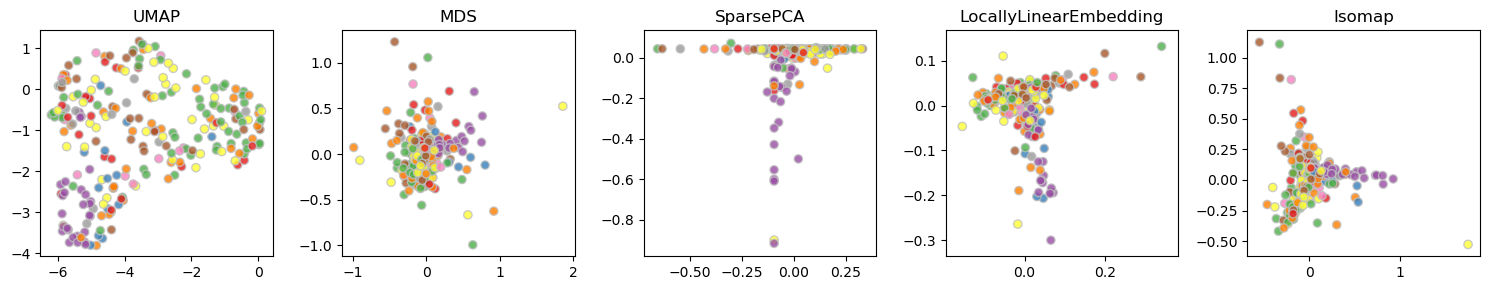

In [29]:
show_visualizations(vizzes1, y, cmap='Set1', edgecolor='silver', alpha=0.8)
show_visualizations(vizzes2, y, cmap='Set1', edgecolor='silver', alpha=0.8)
show_visualizations(vizzes3, y, cmap='Set1', edgecolor='silver', alpha=0.8)

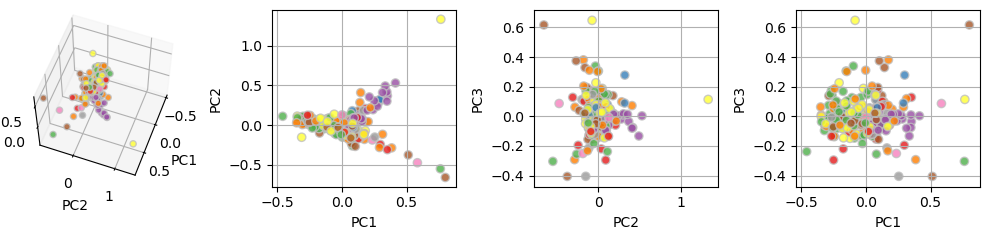

In [30]:
scatter2d3d(pd.DataFrame(PCA(3).fit_transform(X_minmax), columns=['PC1', 'PC2', 'PC3']), (60,20), 
            c=y, figsize=(10,2.5), edgecolor='silver', cmap='Set1', alpha=0.8)
plt.show()

In [31]:
import altair as alt

In [32]:
df_altair = pd.DataFrame()
df_altair['X_mds'], df_altair['Y_mds'] = vizzes1['MDS'].T[0], vizzes1['MDS'].T[1]
df_altair['X_pca'], df_altair['Y_pca'] = vizzes1['PCA'].T[0], vizzes1['PCA'].T[1]
df_altair['X_lle'], df_altair['Y_lle'] = vizzes3['LocallyLinearEmbedding'].T[0], vizzes3['LocallyLinearEmbedding'].T[1]
df_altair['X_iso'], df_altair['Y_iso'] = vizzes3['Isomap'].T[0], vizzes3['Isomap'].T[1]
df_altair['ticker'] = df.ticker
df_altair['sector'] = df_raw.sector
df_altair['mcap'] = np.sqrt(df_raw.marketcap.astype(float))

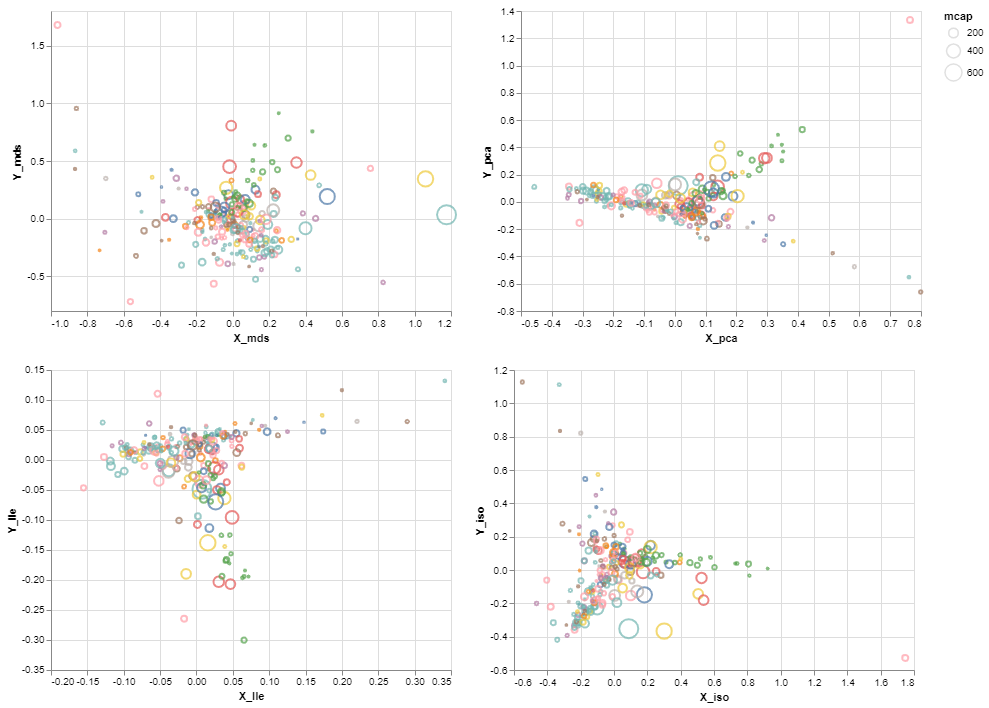

In [33]:
input_dropdown = alt.binding_select(options=list(np.unique(df_altair.sector.values)))
interval = alt.selection_interval(encodings=['x', 'y'])
selection = alt.selection_single(fields=['sector'], bind=input_dropdown, name='LOL')
color = alt.condition(selection,
                    alt.Color('sector:N', legend=None),
                    alt.value('lightgray'))

chart2 = alt.Chart(df_altair).mark_point().encode(
    color=color,
    tooltip='ticker:N',
    size='mcap'
).add_selection(
    selection
).add_selection(
    interval
)

(chart2.encode(x='X_mds', y='Y_mds') | chart2.encode(x='X_pca', y='Y_pca')) &\
(chart2.encode(x='X_lle', y='Y_lle') | chart2.encode(x='X_iso', y='Y_iso'))

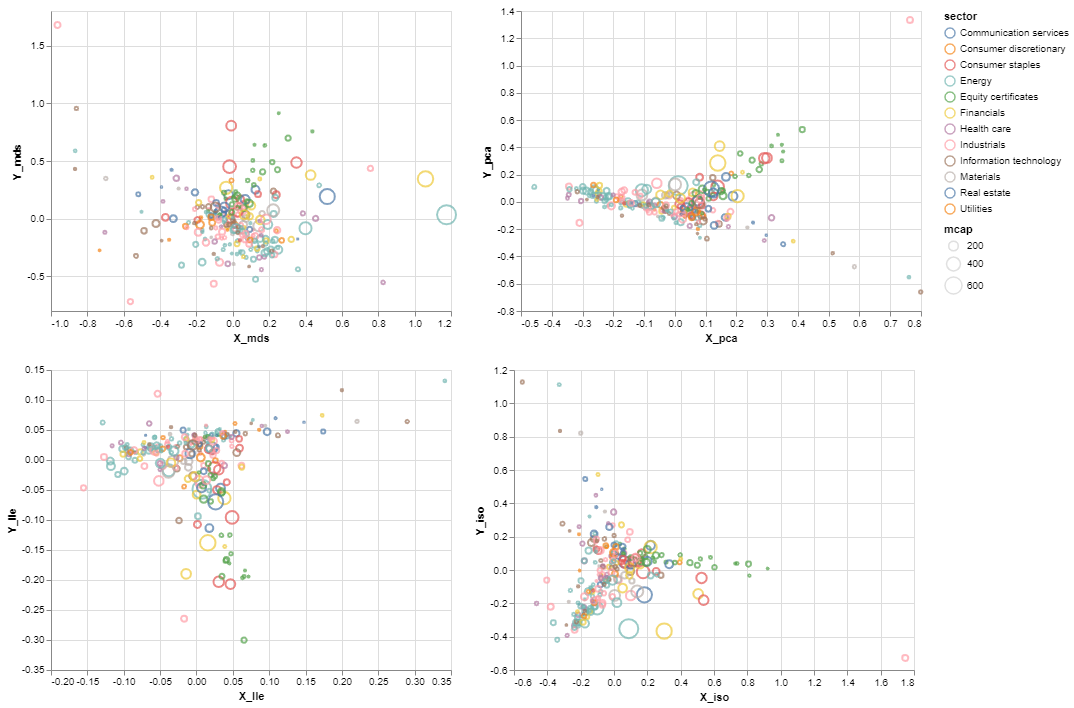

In [34]:
interval = alt.selection_interval(encodings=['x', 'y'])

chart = alt.Chart(df_altair).mark_point().encode(
    color=alt.condition(interval, 'sector', alt.value('lightgray')),
    tooltip=['ticker'],
    size='mcap',
).properties(selection=interval)

(chart.encode(x='X_mds', y='Y_mds') | chart.encode(x='X_pca', y='Y_pca')) &\
(chart.encode(x='X_lle', y='Y_lle') | chart.encode(x='X_iso', y='Y_iso'))

In [35]:
iforest = IsolationForest(behaviour='new', contamination='auto', n_estimators=256, n_jobs=-1, random_state=seed, bootstrap=True, max_features=6)

In [36]:
iforest.fit(df_altair[df_altair.columns[:8]].values)

IsolationForest(behaviour='new', bootstrap=True, contamination='auto',
                max_features=6, max_samples='auto', n_estimators=256, n_jobs=-1,
                random_state=42069, verbose=0, warm_start=False)

In [37]:
scores = iforest.score_samples(df_altair[df_altair.columns[:8]].values)

In [38]:
df_altair_scored = df_altair.copy()
df_altair_scored['scores'] = -scores
print_html(df_altair_scored.sample(5))

,X_mds,Y_mds,X_pca,Y_pca,X_lle,Y_lle,X_iso,Y_iso,ticker,sector,mcap,scores
14,-0.118599,-0.161817,-0.055041,-0.106268,0.000173,0.036842,-0.089584,0.023279,ABT,Materials,6.342712,0.407437
214,0.016651,-0.083483,-0.061853,-0.006558,-0.031121,0.014962,-0.008604,-0.060855,SUBC,Energy,174.973227,0.400769
35,0.172259,-0.330072,-0.344540,0.052962,-0.103805,0.029078,-0.240249,-0.332211,BGBIO,Health care,34.315594,0.493803
58,0.057784,-0.050563,-0.062603,0.004277,-0.010625,-0.002252,0.021673,-0.054343,ELK,Materials,118.067015,0.401770
225,-0.095879,0.099557,0.080913,-0.011283,-0.005164,0.025071,0.113574,0.051532,TIETOO,Information technology,184.673550,0.410986


In [39]:
top20 = df_altair_scored.sort_values(by='scores', ascending=False).head(20)

In [40]:
print_html(top20)

,X_mds,Y_mds,X_pca,Y_pca,X_lle,Y_lle,X_iso,Y_iso,ticker,sector,mcap,scores
18,-0.964231,1.678481,0.764283,1.334581,-0.016982,-0.264417,1.747061,-0.527361,AFK,Industrials,76.170598,0.798410
164,-0.860484,0.955783,0.799019,-0.660814,0.289757,0.064075,-0.549914,1.127828,PLT,Information technology,24.341528,0.762958
165,-0.867217,0.588312,0.760798,-0.551432,0.341490,0.131859,-0.328300,1.112283,PRS,Energy,16.854376,0.759106
217,-0.867604,0.430781,0.513137,-0.376585,0.199967,0.116252,-0.324354,0.834483,TEONE-ME,Information technology,12.336126,0.703893
128,-0.699260,0.348774,0.583571,-0.475168,0.220826,0.064453,-0.199388,0.821264,NOM,Materials,24.305761,0.684628
204,0.304117,0.697759,0.413952,0.530657,0.065450,-0.300272,0.806912,0.035681,MORG,Equity certificates,56.018211,0.660494
193,0.252159,0.913768,0.335126,0.492810,0.066723,-0.184149,0.922282,0.008637,SOGN,Equity certificates,8.149233,0.635342
186,0.358075,-0.438087,-0.456816,0.110687,-0.128919,0.062526,-0.340610,-0.419017,SDRL,Energy,35.479572,0.633294
234,-0.563583,-0.718710,-0.083182,-0.074824,-0.155264,-0.046455,-0.403497,-0.060574,VOW,Industrials,57.753268,0.628701
112,0.437381,0.757323,0.347706,0.418592,0.045066,-0.172162,0.812523,-0.034216,LSTSB-ME,Equity certificates,11.224972,0.621171


In [42]:
print_html(df_raw.loc[df_raw['ticker'].isin(top20.ticker)].loc[top20.index])

,ticker,name,sector,last_,buy,sell,tradecount,info,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
18,AFK,Arendals Fossekompani,Industrials,2650.00,2610.00,2650.00,1,NaN,5801.96,0.0000,0.0038,-0.0112,0.0076,-0.2055,1387.583,5.471961e+09,22.268,NaN,1.909796,0.223481,0.00994
164,PLT,poLight,Information technology,73.00,72.50,73.50,258,LP,592.51,-0.0629,0.4608,1.0580,0.9005,1.5690,19.955,5.676170e+08,-7.262,NaN,3.708344,NaN,0.00000
165,PRS,Prosafe,Energy,3.47,3.47,3.50,587,NaN,284.07,0.1290,0.0937,0.7588,0.6584,-0.7863,0.161,1.486073e+09,-4.461,-0.95,21.490685,0.643724,-1.52121
217,TEONE-ME,TargetEveryOne,Information technology,1.27,1.17,1.22,26,NaN,152.18,0.1239,-0.1806,0.9242,0.1651,-0.3135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,NOM,Nordic Mining,Materials,3.50,3.48,3.50,185,NaN,590.77,0.0294,0.1589,0.6588,0.6355,0.5383,1.061,5.567640e+08,0.142,-0.18,3.298775,1.452631,0.00000
204,MORG,Sparebanken Møre,Equity certificates,319.00,316.00,319.00,12,LP,3138.04,0.0000,0.0031,0.0063,0.0063,0.1788,694.272,3.077102e+10,32.558,30.98,0.459474,0.100404,0.43812
193,SOGN,Sogn Sparebank,Equity certificates,105.00,103.00,106.00,0,LP,66.41,NaN,NaN,-0.0094,-0.0187,0.0202,1411.696,-7.422935e+08,7.366,NaN,0.074379,-0.083400,0.26904
186,SDRL,Seadrill,Energy,12.59,12.45,12.59,222,NaN,1258.80,-0.0319,-0.2209,-0.3259,-0.3927,-0.8390,18.559,7.127875e+09,-13.897,-6.60,0.678377,NaN,-1.22844
234,VOW,Vow,Industrials,31.30,31.20,31.40,534,LP,3335.44,-0.0959,-0.0853,0.0687,0.0367,5.1714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,LSTSB-ME,Lillestrøm Sparebank,Equity certificates,126.00,123.00,127.00,0,LP,126.00,NaN,NaN,NaN,0.0500,0.2273,877.957,2.758230e+09,90.434,NaN,0.143515,0.247384,0.49807


In [49]:
print_html(df_raw[df_raw.sector == 'Communication services'].sort_values(by='priceToBook').describe())

,last_,buy,sell,tradecount,marketcap,profit_today,profit_1wk,profit_1month,profit_ytd,profit_1yr,bookValue,enterpriseValue,trailingEps,forwardEps,priceToBook,beta,profitMargins
count,12.00000,11.000000,11.000000,12.000000,12.000000,10.000000,10.000000,11.000000,11.000000,8.000000,10.000000,1.100000e+01,10.000000,3.000000,8.000000,8.000000,11.000000
mean,81.87000,89.052727,89.477273,175.416667,32536.290000,-0.006340,0.024220,0.045691,0.040464,0.040400,16.669700,5.580211e+10,0.523000,6.170000,10.132971,0.379276,-0.253910
std,102.33382,103.807388,103.815158,382.891738,67329.911215,0.019111,0.124543,0.157466,0.146885,0.501738,21.830368,1.085087e+11,3.208254,5.434584,10.307124,0.464648,0.635551
min,0.04000,0.040000,0.040000,0.000000,1.300000,-0.026000,-0.161400,-0.260400,-0.290000,-0.760700,-3.150000,1.139069e+07,-6.556000,-0.050000,0.777137,-0.239095,-2.025120
25%,12.87750,16.650000,16.880000,4.000000,988.680000,-0.018600,-0.040950,-0.012750,0.039700,-0.141975,0.276000,1.723291e+09,-0.626000,4.255000,4.977021,0.111335,-0.196885
50%,27.20000,37.000000,39.400000,33.500000,2901.480000,-0.013750,0.000350,0.042700,0.056800,0.259050,2.843500,7.680950e+09,-0.052500,8.560000,6.342065,0.351012,0.034570
75%,121.76250,136.125000,136.450000,158.500000,30660.302500,0.000000,0.054625,0.126250,0.093850,0.344350,40.328750,7.392876e+10,2.718000,9.280000,10.962355,0.484007,0.047610
max,281.30000,281.000000,281.300000,1359.000000,234526.010000,0.040000,0.253500,0.294700,0.289700,0.543100,47.868000,3.676247e+11,5.006000,10.000000,29.140890,1.302454,0.085800
